<a href="https://colab.research.google.com/github/Frinhani/LearningMachineLearning/blob/main/bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
dados = pd.read_csv('/content/drive/MyDrive/Files/Bicicletas.csv')
dados.head()

,clima,temperatura,bicicletas_alugadas
0,2,0.363625,985
1,2,0.353739,801
2,1,0.189405,1349
3,1,0.212122,1562
4,1,0.229270,1600


In [3]:
dados.shape

(731, 3)

Text(0, 0.5, 'bikes_alugadas')

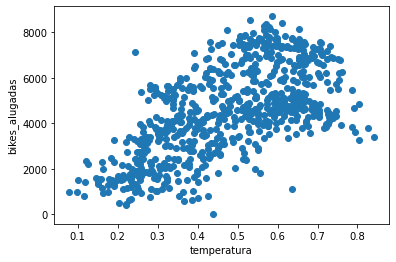

In [4]:
plt.scatter(dados['temperatura'], dados['bicicletas_alugadas'])
plt.xlabel('temperatura')
plt.ylabel('bikes_alugadas')

([<matplotlib.axis.XTick at 0x7f97a6997890>,
 <a list of 3 Text major ticklabel objects>)

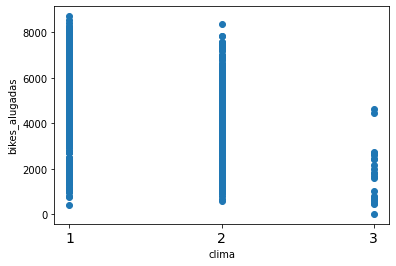

In [5]:
plt.scatter(dados.clima, dados.bicicletas_alugadas)
plt.ylabel('bikes_alugadas')
plt.xlabel('clima')
indice=[1,2,3]
plt.xticks(indice, fontsize=14)

In [6]:
y = dados.bicicletas_alugadas.values

In [7]:
X = dados[['clima', 'temperatura']].values

In [8]:
X = X/np.amax(X,axis=0)

In [9]:
print(X)

[[0.66666667 0.43242565]
 [0.66666667 0.42066914]
 [0.33333333 0.22524188]
 ...
 [0.66666667 0.28826395]
 [0.33333333 0.27553942]
 [0.66666667 0.26577246]]


In [10]:
ymax = np.amax(y)
y = y/ymax

In [11]:
def sigmoid(Soma):
  return 1/(1+np.exp(-Soma))

In [12]:
def relu(Soma):
  return np.maximum(0, Soma)

In [55]:
arquitetura = [{
    'dim_entrada':2,
    'dim_saida':128,
    'ativacao': 'relu'},
    {
    'dim_entrada':128,
    'dim_saida':1,
    'ativacao':'sigmoid'
    }]

In [14]:
def inicia_camadas(arquitetura, seed = 99):

  np.random.seed(seed)
  numero_de_camadas = len(arquitetura)
  valores_parametros = {}

  for indice, camada in enumerate(arquitetura):

    indice_camada = indice + 1

    tamanho_camada_entrada = camada['dim_entrada']
    tamanho_camada_saida = camada['dim_saida']

    valores_parametros['P' + str(indice_camada)] = np.random.randn(tamanho_camada_saida, tamanho_camada_entrada) # * 0.1
    valores_parametros['b' + str(indice_camada)] = np.random.randn(tamanho_camada_saida, 1) * 0.1

  return valores_parametros

In [15]:
def propaga_uma_camada(Ativado_anterior, Pesos_atual,  b_atual, ativacao = 'relu'):
  Saida_atual =  np.dot(Pesos_atual, Ativado_anterior) + b_atual

  if ativacao is 'relu':
    func_ativacao = relu
  elif ativacao is 'sigmoid':
    func_ativacao = sigmoid

  return func_ativacao(Saida_atual), Saida_atual

In [16]:
def propaga_total(X, valores_parametros, arquitetura):
  memoria = {}
  Ativado_atual = X

  for indice, camada in enumerate(arquitetura):

    indice_camada = indice + 1
    Ativado_anterior = Ativado_atual

    func_ativacao_atual = camada['ativacao']
    Pesos_atual = valores_parametros['P' + str(indice_camada)]
    b_atual = valores_parametros['b' + str(indice_camada)]

    Ativado_atual, Saida_atual = propaga_uma_camada(Ativado_anterior, Pesos_atual,
                       b_atual, func_ativacao_atual)
    
    memoria['A' + str(indice)] = Ativado_anterior
    memoria['Z' + str(indice_camada)] = Saida_atual

  return Ativado_atual, memoria

In [17]:
valores_parametros = inicia_camadas(arquitetura,seed=99)

In [18]:
y_estimado, memoria = propaga_total(np.transpose(X), valores_parametros, arquitetura)

In [19]:
y_estimado[0,0]

0.000528786918976693

In [20]:
y_estimado[0,0]*ymax

4.607849211962902

In [21]:
y[0]*ymax

985.0000000000001

In [22]:
def valor_de_custo(Y_predito, Y):
  m = Y_predito.shape[1]
  custo = -1/m *(np.dot(Y, np.log(Y_predito).T) + np.dot(1 - Y, np.log( 1 - Y_predito ).T))
  return np.squeeze(custo)

In [23]:
def atualiza(valores_parametros, gradidentes, arquitetura, taxa_aprendizagem):

    for indice_camada, camada in enumerate(arquitetura, 1):
        valores_parametros["P" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["dP" + str(indice_camada)]        
        valores_parametros["b" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["db" + str(indice_camada)]

    return valores_parametros

In [24]:
def retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura):
  gradientes = {}
  
  Y = Y.reshape(Y_predito.shape)
  dAtivado_anterior = -(np.divide(Y, Y_predito) - np.divide(1-Y,1-Y_predito))

  for indice_camada_anterior, camada in reversed(list(enumerate(arquitetura))):
    indice_camada_atual = indice_camada_anterior + 1
    funcao_ativacao_atual = camada['ativacao']

    dAtivado_atual = dAtivado_anterior

    Ativado_anterior = memoria['A' + str(indice_camada_anterior)]
    Saida_atual = memoria['Z' + str(indice_camada_atual)]
    Pesos_atual = valores_parametros['P' + str(indice_camada_atual)]
    b_atual = valores_parametros['b' + str(indice_camada_atual)]

    dAtivado_anterior, dPesos_atual, db_atual = retropropagacao_uma_camada(
        dAtivado_atual, Pesos_atual, b_atual, Saida_atual, Ativado_anterior, funcao_ativacao_atual)
    gradientes['dP' + str(indice_camada_atual)] = dPesos_atual
    gradientes['db' + str(indice_camada_atual)] = db_atual

  return gradientes

In [25]:
def sigmoid_retro(dAtivado, Saida):
  sig = sigmoid(Saida)
  return dAtivado * sig * (1-sig)

In [26]:
def relu_retro(dAtivado, Saida):
  dSaida = np.array(dAtivado, copy=True)
  dSaida[Saida <= 0] = 0
  return dSaida

In [27]:
def retropropagacao_uma_camada(dAtivado_atual, Pesos_atual, b_atual, Saida_atual,
                               Ativado_anterior, ativacao='relu'):
  m = Ativado_anterior.shape[1]

  if ativacao is 'relu':
    func_ativacao_retro = relu_retro
  elif ativacao is 'sigmoid':
    func_ativacao_retro = sigmoid_retro
  else:
    raise Exception('Ainda não implementado')

  dSaida_atual = func_ativacao_retro(dAtivado_atual, Saida_atual)
  dPesos_atual = np.dot(dSaida_atual, Ativado_anterior.T) / m
  db_atual = np.sum(dSaida_atual, axis=1, keepdims=True) / m
  dAtivado_anterior = np.dot(Pesos_atual.T, dSaida_atual)
  return dAtivado_anterior, dPesos_atual, db_atual



In [36]:
def treino(X,Y,X_teste,Y_teste, arquitetura, epocas, taxa_aprendizagem):

  valores_parametros = inicia_camadas(arquitetura, 2)

  historia_custo = []
  historia_custo_teste = []

  for i in range(epocas):
    Y_predito, memoria = propaga_total(X, valores_parametros, arquitetura)
    Y_predito_teste, memoria2 = propaga_total(X_teste, valores_parametros, arquitetura)

    custo = valor_de_custo(Y_predito, Y)
    historia_custo.append(custo)
    custo_teste = valor_de_custo(Y_predito_teste, Y_teste)
    historia_custo_teste.append(custo_teste)

    gradientes = retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura)

    valores_parametros = atualiza(valores_parametros, gradientes, arquitetura, taxa_aprendizagem)

        
    if(i % 50 == 0):
      print("Iteração: {:05} - custo: {:.5f} ".format(i, custo))

  return valores_parametros, historia_custo, historia_custo_teste

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.43, random_state=43)

In [56]:
valores_parametros, historia_custo, historia_custo_teste = treino(
    np.transpose(X_treino), np.transpose(y_treino.reshape((y_treino.shape[0], 1))), 
    np.transpose(X_teste), np.transpose(y_teste.reshape((y_teste.shape[0], 1))),
    arquitetura,epocas = 20000, taxa_aprendizagem=0.01)

Iteração: 00000 - custo: 2.70205 
Iteração: 00050 - custo: 0.71194 
Iteração: 00100 - custo: 0.68662 
Iteração: 00150 - custo: 0.67047 
Iteração: 00200 - custo: 0.66027 
Iteração: 00250 - custo: 0.65383 
Iteração: 00300 - custo: 0.64938 
Iteração: 00350 - custo: 0.64623 
Iteração: 00400 - custo: 0.64397 
Iteração: 00450 - custo: 0.64232 
Iteração: 00500 - custo: 0.64111 
Iteração: 00550 - custo: 0.64019 
Iteração: 00600 - custo: 0.63947 
Iteração: 00650 - custo: 0.63887 
Iteração: 00700 - custo: 0.63838 
Iteração: 00750 - custo: 0.63797 
Iteração: 00800 - custo: 0.63763 
Iteração: 00850 - custo: 0.63734 
Iteração: 00900 - custo: 0.63708 
Iteração: 00950 - custo: 0.63685 
Iteração: 01000 - custo: 0.63666 
Iteração: 01050 - custo: 0.63649 
Iteração: 01100 - custo: 0.63635 
Iteração: 01150 - custo: 0.63622 
Iteração: 01200 - custo: 0.63610 
Iteração: 01250 - custo: 0.63600 
Iteração: 01300 - custo: 0.63589 
Iteração: 01350 - custo: 0.63580 
Iteração: 01400 - custo: 0.63571 
Iteração: 0145

Text(0.5, 0, 'Épocas')

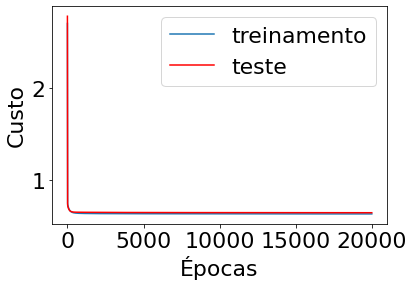

In [57]:
plt.plot(historia_custo)
plt.plot(historia_custo_teste, 'r')
plt.legend(['treinamento', 'teste'])
plt.ylabel("Custo")
plt.xlabel('Épocas')


In [58]:
Y_pred, _ = propaga_total(np.transpose(X_teste), valores_parametros, arquitetura)

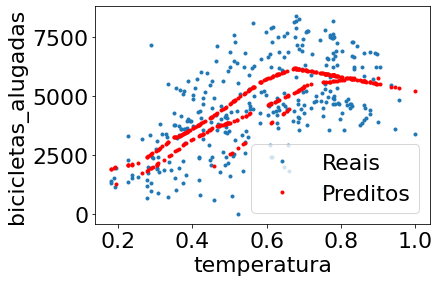

In [59]:
plt.plot(np.transpose(X_teste)[1], ymax*y_teste, '.')
plt.plot(np.transpose(X_teste)[1], ymax*Y_pred.reshape([-1,1]), '.r')
plt.legend(['Reais', 'Preditos'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('temperatura')
plt.show()

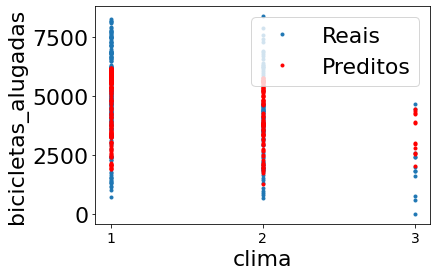

In [60]:
plt.plot(3*np.transpose(X_teste)[0], ymax*y_teste, '.')
plt.plot(3*np.transpose(X_teste)[0], ymax*Y_pred.reshape([-1,1]), '.r')
plt.legend(['Reais', 'Preditos'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('clima')
plt.rcParams.update({'font.size': 22})
indice = [ 1,2,3]
plt.xticks(indice, fontsize = 14)
plt.show()